<a href="https://colab.research.google.com/github/aminecloud9/PFE/blob/main/UNSW_NB15_Originaldata_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
pip install git+https://github.com/artemmavrin/focal-loss.git

In [ ]:
pip install focal-loss

Download dataset

In [48]:
#data=pd.read_csv('/content/drive/MyDrive/CICIDS2017_multi_class_StandardScaler_NormalsationResults.csv')
#train_data = pd.read_csv('/content/drive/MyDrive/KDDTrain+.csv', header = None,nrows=1) # read just first line for columns
#columns = train_data.columns.tolist() # get the columns
#cols_to_use = columns[:len(columns)-1] 
train_data=pd.read_csv('/content/drive/MyDrive/UNSW_NB15_training.csv')
train_data = train_data.iloc[:, :-1]# drop the last one
test_data=pd.read_csv('/content/drive/MyDrive/UNSW_NB15_testing.csv')
test_data = test_data.iloc[:, :-1]# drop the last one

In [58]:
train_y[0]

array([0, 0, 0, ..., 0, 0, 0])

Data nemerisation

In [56]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
train_data[["proto"]] = enc.fit_transform(train_data[["proto"]])
test_data[["proto"]] = enc.fit_transform(test_data[["proto"]])

train_data[["service"]] = enc.fit_transform(train_data[["service"]])
test_data[["service"]] = enc.fit_transform(test_data[["service"]])

train_data[["state"]] = enc.fit_transform(train_data[["state"]])
test_data[["state"]] = enc.fit_transform(test_data[["state"]])


Train and test data formatting

In [64]:
train_X = train_data.values[:,:-1]
train_y = pd.factorize(train_data.values[:,-1])
test_X = test_data.values[:,:-1]
test_y = pd.factorize(test_data.values[:,-1])

Data scaling

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X=scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

Class=0, n=56000 (2800000.000%)
Class=1, n=1746 (87300.000%)
Class=2, n=2000 (100000.000%)
Class=3, n=18184 (909200.000%)
Class=4, n=1133 (56650.000%)
Class=5, n=10491 (524550.000%)
Class=6, n=33393 (1669650.000%)
Class=7, n=12264 (613200.000%)
Class=8, n=130 (6500.000%)
Class=9, n=40000 (2000000.000%)


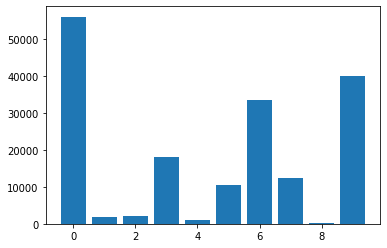

In [66]:
# summarize distribution
from collections import Counter
counter = Counter(train_y[0])
for k,v in counter.items():
	per = v / len(train_y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Data augmentation

In [ ]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# transform the dataset
oversample = SMOTE()
train_X, train_y = oversample.fit_resample(train_X, train_y[0])
# summarize the new class distribution
counter = Counter(train_y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(train_y == label)[0]
	pyplot.scatter(train_X[row_ix, 0], train_X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

pyplot.bar(counter.keys(), counter.values())
pyplot.show()

reshape input to be [samples, time steps, features]

In [67]:
import keras
#X_train = np.reshape(data.values[:,:-1].astype('float32'), (data.values[:,:-1].shape[0], 1, data.values[:,:-1].shape[1]))
X_train = np.reshape(train_X.astype('float32'), (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X.astype('float32'), (test_X.shape[0], 1, test_X.shape[1]))
#y_train = keras.utils.to_categorical(pd.factorize(data.values[:,77])[0],15)
y_train = keras.utils.to_categorical(train_y[0],train_y[1].shape[0])
y_train = y_train.astype('int')
y_train = np.reshape(y_train,(y_train.shape[0],1,y_train.shape[1]))
y_test = keras.utils.to_categorical(test_y[0],train_y[1].shape[0])
y_test = y_test.astype('int')
y_test = np.reshape(y_test,(y_test.shape[0],1,y_test.shape[1]))

In [70]:
X_test.shape

(82332, 1, 43)

Define the network

In [ ]:
import time
#train_object_num=len(train_data)
#print(test[0])
#model training
batch_size = 1024
model=Sequential()
model.add(LSTM(X_train.shape[2],input_dim=X_train.shape[2],return_sequences=True,kernel_initializer='uniform',activation='relu'))
model.add(LSTM(32,kernel_initializer='uniform',return_sequences=True,activation='relu'))
model.add(LSTM(32,kernel_initializer='uniform',activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(y_train.shape[2],activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='NADAM',metrics=['accuracy'])
model.summary()
start_time = time.time()
history = model.fit(train_X,train_y,validation_split=.3,epochs=100,batch_size=batch_size,verbose=1)
finish_time = time.time() - start_time
model.save("/content/drive/My Drive/model_NSL-KDD_scaled_Multiclass_valsplit.3_bs1024_100ep.h5")

In [74]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
loss, accuracy = model.evaluate(X_test,y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
y_pred = model.predict_classes(X_test)
target_names = ['Normal', 'Dos', 'Probe','R2L', 'U2R']
print(classification_report(y_true = np.transpose(test_y[0]), y_pred = y_pred))
#print(accuracy_score(y_true = np.transpose(test_y[0]), y_pred = y_pred))
print("execution time :  ",finish_time)

2573/2573 [==============================] - 13s 5ms/step - loss: 2.8046 - accuracy: 0.4766

Loss: 2.80, Accuracy: 47.66%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.70      0.56      0.62     37000
           1       0.06      0.01      0.01      3496
           2       0.00      0.00      0.00       583
           3       0.02      0.07      0.02      4089
           4       0.00      0.00      0.00     11132
           5       0.00      0.00      0.00       677
           6       0.06      0.13      0.08      6062
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       378
           9       0.99      0.92      0.95     18871

    accuracy                           0.48     82332
   macro avg       0.18      0.17      0.17     82332
weighted avg       0.55      0.48      0.51     82332



NameError: ignored

saving model

In [ ]:
model.save("/content/drive/MyDrive/NSL-KDD_42norm_results_5Dense_po_Dropout_200epoch_1024batch_model.h5")

In [ ]:
from keras.models import load_model
#model = load_model('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_model.hdf5')
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

#print("--- %s seconds ---",finish_time)
y_pred = model.predict(X_train)
#np.savetxt('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_predicted.txt', np.transpose([y_test,y_pred]), fmt='%s')

In [ ]:
y_pred

In [ ]:
42 col pca 80% : b_s=256 epochs= 300 Lstm(32,32)->Dense(256,128,64,ytrain.shape(2))   ->   accuracy = 62.8%


24 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 83.73%
24 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 40.28%
42 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 48.52%
42 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 45.22%


In [71]:
batch_size= 1024
lrate = 0.1
model = Sequential()
model.add(Dense(X_train.shape[2], input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1024, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(768, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(512, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(256, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(128, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(y_train.shape[2], activation='softmax'))
	# compile model
opt = SGD(lr=lrate)
#loss = categorical_focal_loss([67343,45927,995,11656,52])
model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, validation_split=.3,batch_size=batch_size, epochs=10, verbose=1)

Epoch 1/10
120/120 [==============================] - 23s 187ms/step - loss: 1.1609 - accuracy: 0.6103 - val_loss: 0.5348 - val_accuracy: 0.8516
Epoch 2/10
120/120 [==============================] - 22s 185ms/step - loss: 0.7185 - accuracy: 0.7291 - val_loss: 0.4747 - val_accuracy: 0.8631
Epoch 3/10
120/120 [==============================] - 22s 186ms/step - loss: 0.6791 - accuracy: 0.7404 - val_loss: 0.4564 - val_accuracy: 0.8658
Epoch 4/10
120/120 [==============================] - 22s 185ms/step - loss: 0.6485 - accuracy: 0.7518 - val_loss: 0.4340 - val_accuracy: 0.8723
Epoch 5/10
120/120 [==============================] - 22s 185ms/step - loss: 0.6277 - accuracy: 0.7600 - val_loss: 0.4362 - val_accuracy: 0.8719
Epoch 6/10
120/120 [==============================] - 22s 185ms/step - loss: 0.6107 - accuracy: 0.7636 - val_loss: 0.4210 - val_accuracy: 0.8734
Epoch 7/10
120/120 [==============================] - 22s 186ms/step - loss: 0.6058 - accuracy: 0.7641 - val_loss: 0.4206 - val_ac

Text(0.5, 1.0, 'lrate=0.1')

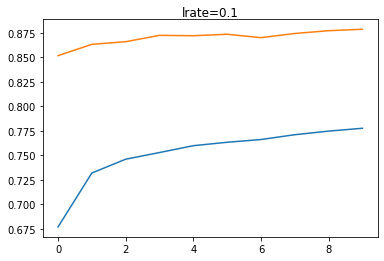

In [72]:
from matplotlib import pyplot
# plot accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)


Text(0.5, 1.0, 'lrate=0.1')

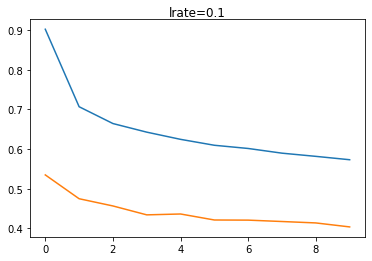

In [73]:

# plot leoss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)